# Packages

In [1]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import quandl
import math
import re
from datetime import datetime

# normalization
from sklearn.preprocessing import StandardScaler

# statsmodel.tsa (Time series)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# sklearn (ica, train_test_split)
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split

# cmeans
import skfuzzy as fuzz

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Functions

In [3]:
# 0. Data clear
def datelist(beginDate, endDate):
    # beginDate, endDate是形如‘20160601’的字符串或datetime格式
    date_l=[datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

##############################################################################################################
def data_clear(data,start_day,end_day):
    
    data = data.loc[:,["Date","Close"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="Date" , how="left")
    
    for i in range(len(df)):
        if df.Date[i] is np.nan:
            df.Close[i] = df.Close[i-1]
            
    df = df.loc[:,["date","Close"]]
    df.columns=["Date","Price"]
    
    return df

##############################################################################################################
def data_clear_eth(data,start_day,end_day):
    
    data = data.loc[:,["Date","Close"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="Date" , how="left")
    
    for i in range(len(df)):
        if math.isnan(df.Close[i]):
            df.Close[i] = df.Close[i-1]

            
    df = df.loc[:,["date","Close"]]
    df.columns=["Date","Price"]
    
    return df

##############################################################################################################
def data_clear_ethv(data,start_day,end_day):
    
    data = data.loc[:,["Date","Volume"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="Date" , how="left")
    
    for i in range(len(df)):
        if math.isnan(df.Volume[i]):
            df.Volume[i] = df.Volume[i-1]

            
    df = df.loc[:,["date","Volume"]]
    df.columns=["Date","Volume"]
    
    return df

##############################################################################################################
def data_clear_hash(data,start_day,end_day):
    
    start = np.where(data.Date ==start_day)[0][0]
    
    try:
        end = np.where(data.Date ==end_day)[0][0]
        d_has = data.iloc[start:end+1,:]
        d_has.reset_index(drop=True,inplace=True)
    except:
        end = data.index[-1]
        d_has = data.iloc[start:end+1,:]
        d_has.reset_index(drop=True,inplace=True)
        d_has = d_has.append({"Date":end_day,"Value":d_has.iloc[-1,1]},ignore_index=True)
        
    return d_has

##############################################################################################################
def sp_clear(data):
    
    data = data[::-1]
    data.reset_index(drop=True,inplace=True)
    
    data.日期 = data.日期.apply(lambda x : re.sub("年","-",x))
    data.日期 = data.日期.apply(lambda x : re.sub("月","-",x))
    data.日期 = data.日期.apply(lambda x : re.sub("日","",x))
    
    return data

def fill_zero(string):
    an = string.split("-")
    
    ans = []
    for i in an[1:]:
        if len(i)<2:
            ans.append("0" + i)
        else :
            ans.append(i)
            
            
    date = "-".join((an[0],ans[0],ans[1]))
    
    return date
    
def data_clear_sp(data,start_day,end_day):
    
    data = data.loc[:,["日期","收市"]] 
    a = pd.DataFrame({"date":datelist(start_day,end_day)})
    
    df = pd.merge(a, data, left_on="date", right_on="日期" , how="left")
    
    for i in range(len(df)):
        if df.日期[i] is np.nan:
            df.收市[i] = df.收市[i-1]
            
    df = df.loc[:,["date","收市"]]
    df.columns=["Date","Price"]
    
    return df

##############################################################################################################
def data_clear_Volume(data,start_day,end_day):
    
    data = data[::-1]
    
    start = np.where(data.date ==start_day)[0][0]
    end = np.where(data.date ==end_day)[0][0]
    
    d_vol = data.iloc[start:end+1,[1,7]]
    d_vol.reset_index(drop=True,inplace=True)
    
    return d_vol

##############################################################################################################
def data_cl(NAS,Eth,Ethv,TSLA,NVI,Has,SP,
    start_day,end_day):
    
    df_nas = data_clear(NAS,start_day,end_day)
    df_eth = data_clear_eth(Eth ,start_day,end_day)
    df_ethv = data_clear_ethv(Ethv ,start_day,end_day)
    df_tsla  = data_clear(TSLA,start_day,end_day)
    df_nvi  = data_clear(NVI ,start_day,end_day)
    
    has = Has.reset_index() 
    df_has  = data_clear_hash(has,start_day,end_day)
    
    sp = sp_clear(SP)
    sp.日期 = sp.日期.apply(fill_zero)
    df_sp  = data_clear_sp(sp,start_day,end_day)
    
    
    return df_nas,df_eth,df_ethv,df_tsla,df_nvi,df_has,df_sp

##############################################################################################################
# Bitcoin price Y

def data_clear_Price(data,start_day,end_day):
    
    data = data[::-1]
    data = data.reset_index(drop = True)
    
    start = np.where(data.date ==start_day)[0][0]
    
    try:
        end = np.where(data.date ==end_day)[0][0]
        d_pr = data.iloc[start:end+1,[1,6]]
        d_pr.reset_index(drop=True,inplace=True)
    
    except:
        end = data.index[-1]
        d_pr = data.iloc[start:end+1,[1,6]]
        d_pr.reset_index(drop=True,inplace=True)
        
        
        dup = pd.Series(np.repeat(d_pr.iloc[-1,-1],24))
        dup.index=[i+end-start+1 for i in range(24)]
        
        d_pr = pd.concat([d_pr.loc[:,'close'],dup],axis=0)
        
    return d_pr

In [4]:
# 1. Time series decomposition (to deal with bitcoin price data)
def additive_decompose(data, periods = 2160):
    '''
    Time series additive decomposition 
    Arguments:
    data: pandas DataFrame
    periods: length of seasonal periods
    '''
    result_add = seasonal_decompose(data, model = 'additive', extrapolate_trend = 'freq', period = 2160)
    data_add_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
    data_add_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
    
    # plot
    plt.subplots(figsize = (10, 10))
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

    plt.subplot(4, 1, 1)
    data_add_reconstructed.actual_values.plot()
    plt.subplot(4, 1, 2)
    data_add_reconstructed.trend.plot()
    plt.subplot(4, 1, 3)
    data_add_reconstructed.seas.plot()
    plt.subplot(4, 1, 4)
    data_add_reconstructed.resid.plot()
    return data_add_reconstructed

# 2. sliding windows with 1 lags of timestep (normally for X)
def sliding_windows(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns: Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 3. Special for bitcoin slides or timesteps is not equal to slides you prefer
def bitcoin_slides(data, length = 167, slides = 24, stagger = True, stagger_length = 7, drop_tail = True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    length: Same as n_out in sliding windows function
    slides: Timesteps you prefer. For example, bitcoin slides for one day then slides = 24
    stagger: If X is to stagger with Y?
    stagger_length: Length of staggering (stagger = True)
    drop_tail: In staggering, do you want to drop head or tail? (tail for X, head for Y)
    """
    data_slides = sliding_windows(list(data.values.flatten()), n_out = length)
    data_slides = data_slides.iloc[[i for i in range(0, len(data_slides), slides)],:]
    
    if (stagger == True): # 錯開
        if (drop_tail == True):
            data_slides = data_slides.drop(data_slides.tail(stagger_length).index)
        else:
            data_slides = data_slides.drop(data_slides.head(stagger_length).index)   
    else:
        data_slides = data_slides
        
    data_slides = data_slides.reset_index(drop = True)
    print(data_slides)
    print(data_slides.shape)
    
    # Turn to Numpy
    data_slides_val = data_slides.values
    return data_slides_val

# 4. Prediction handle for teacher
def Predict_for_Teacher(predict, peek_price, shift = True): #46880.48
    
    # trend
    t = log_bit_decomp.trend.values[-2:]
    t_diff = t[1] - t[0]
    trend = t[1] + t_diff*np.arange(1, 169, 1)
    
    # seasonal
    s = log_bit_decomp.seas.values
    remainder = log_bit_decomp.seas.shape[0]%2160 
    seasonal = s[(remainder+1):(remainder+169)]
    
    # prediction
    prediction = np.exp(np.array(predict).flatten() + trend + seasonal)
    
    # smooth result
    windows = 4
    prediction_smooth = pd.DataFrame(prediction).rolling(window = windows).mean()
    prediction_smooth[0:windows-1] = pd.DataFrame(prediction[0:windows-1])
    prediction_smooth = prediction_smooth.values
    
    if (shift == True):
        prediction_first = prediction_smooth[0]
        shift_length = peek_price - prediction_first
        prediction_smooth = prediction_smooth + shift_length 
    
    print('未來一個禮拜價格最低可來到:', np.min(prediction_smooth))
    print('未來一個禮拜價格最高可來到:', np.max(prediction_smooth))
    
    # plot
    plt.plot(prediction_smooth, color = 'red')
    plt.title('Bitcoin Prediction for Next Week (1/10 01:00 A.M. ~ 1/17 00:00 A.M.)')
    
    return prediction_smooth

# Final Project (Be sure to check step by step !!!!!)
- If there is print(data.shape), check the data size carefully
- Two time point: (1) 2019, 1, 3 (Thurs.), 01:00 a.m. ~ (2) 2019, 1, 7 (Mon.), 01:00 a.m. ~
- Under is the example for (1)

## Step 1: Check if GPU is available
- If not (Available = 0), then use normal LSTM instead of CuDNNLSTM

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 3070 Ti


## Step 2: Check data length 
- 1. Bitcoin: 2019, Jan, 3rd, 01:00 A.M ~ (Timestep: 1 hour)
- 2. Input X: 2019, Jan, 3rd, 01:00 A.M ~ (Timestep: 1 day)

### read file

In [6]:
nas = pd.read_csv("^IXIC.csv")
eth = pd.read_csv("ETH-USD.csv")
ethv = pd.read_csv("ETH-USD.csv")
tsla = pd.read_csv("TSLA.csv")
nvi = pd.read_csv("NVDA.csv")
has = quandl.get("BCHAIN/HRATE", authtoken="qj1EhRZ9XZ94sN13sV8j")
sp = pd.read_csv("SPY歷史資料.csv")
bv = pd.read_csv("Bitstamp_BTCUSD_d.csv")
bit = pd.read_csv("Bitstamp_BTCUSD_1h.csv")

### update Data

- Variable X

In [7]:
start_day = "20190107" # 20190103
end_day = "20220109"

In [8]:
# The latest Hash_rate value is often not uploaded

df_nas,df_eth,df_ethv,df_tsla,df_nvi,df_has,df_sp = data_cl(nas,eth,ethv,tsla,nvi,has,sp,start_day,end_day)

C:\Users\Jater\AppData\Local\Temp/ipykernel_20460/2111542685.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Close[i] = df.Close[i-1]
C:\Users\Jater\AppData\Local\Temp/ipykernel_20460/2111542685.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Close[i] = df.Close[i-1]
C:\Users\Jater\AppData\Local\Temp/ipykernel_20460/2111542685.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Close[i] = df.Close[i-1]
C:\Users\Jate

In [9]:
start_day1 = "2019/1/7 00:00"
end_day1 = "2022/1/9 00:00"

In [10]:
df_vol = data_clear_Volume(bv,start_day1,end_day1)

- Price Y

In [11]:
start_day2 = "2019/1/7 01:00" # start in 1:00
end_day2 = "2022/1/10 00:00" # set predict date

In [12]:
# The latest bitcoin price is often not uploaded

bitcoin = data_clear_Price(bit,start_day2 ,end_day2) 

### save file

In [13]:
#df_nas.to_csv("NASDAQ_new.csv",encoding="utf-8-sig")
#df_eth.to_csv("Ethereum_new.csv",encoding="utf-8-sig")
#df_ethv.to_csv("Ethereum_Volume_new.csv",encoding="utf-8-sig")
#df_tsla .to_csv("TSLA_new.csv",encoding="utf-8-sig")
#df_nvi.to_csv("NVIDIA_new.csv",encoding="utf-8-sig")
#df_has.to_csv("Hash rate_new.csv",encoding="utf-8-sig")
#df_sp.to_csv("S&P 500_new.csv",encoding="utf-8-sig")
#df_vol.to_csv("Bitcoin_Volume_new.csv",encoding="utf-8-sig")

#bitcoin.to_csv("Bitcoin_price_new.csv",encoding="utf-8-sig")

### Check shape

In [14]:
print("NASDAQ DIM : {}".format(df_nas.shape))
print("ETH_Price DIM : {}".format(df_eth.shape))
print("ETH_Volume DIM : {}".format(df_ethv.shape))
print("TSLA DIM : {}".format(df_tsla.shape))
print("NVIDIA DIM : {}".format(df_nvi.shape))
print("Hash rate DIM : {}".format(df_has.shape))
print("S&P 500 DIM : {}".format(df_sp.shape))
print("Bitcoin_Volume DIM : {}".format(df_vol.shape))
print("--------------------------------------------------------")
print("Bitcoin_Price DIM : {}".format(bitcoin.shape[0]/24)) 
print("\n--------------------------------------------------------\n\n")

nasdaq = df_nas.iloc[:,-1]
eth = df_eth.iloc[:,-1]
eth_volume = df_ethv.iloc[:,-1]
tesla = df_tsla.iloc[:,-1]
nvidia = df_nvi.iloc[:,-1]
hash = df_has.iloc[:,-1]
sp500 = df_sp.iloc[:,-1]
bit_volume = df_vol.iloc[:,-1]


all_inputs = pd.concat((sp500, nvidia, tesla, nasdaq, hash, eth_volume, eth, bit_volume), axis = 1)
all_inputs.columns = ['SP500', 'NVIDIA', 'TSLA', 'NASDAQ', 'Hash Rate', 'Ethereum Volume', 'Ethereum Price', 'Bitcoin Volume']
all_inputs

NASDAQ DIM : (1099, 2)
ETH_Price DIM : (1099, 2)
ETH_Volume DIM : (1099, 2)
TSLA DIM : (1099, 2)
NVIDIA DIM : (1099, 2)
Hash rate DIM : (1099, 2)
S&P 500 DIM : (1099, 2)
Bitcoin_Volume DIM : (1099, 2)
--------------------------------------------------------
Bitcoin_Price DIM : 1099.0

--------------------------------------------------------




,SP500,NVIDIA,TSLA,NASDAQ,Hash Rate,Ethereum Volume,Ethereum Price,Bitcoin Volume
0,254.38,35.849998,66.991997,6823.470215,3.938157e+07,2712108388,151.699219,7445.096004
1,256.77,34.957500,67.070000,6897.000000,4.720202e+07,2459808140,150.359634,11819.986770
2,257.97,35.645000,67.706001,6957.080078,4.580551e+07,2369241197,150.803116,7390.133992
3,258.88,36.307499,68.994003,6986.069824,4.357110e+07,3397734456,128.625183,16118.420880
4,258.98,37.207500,69.452003,6971.479980,4.133668e+07,2667585234,127.548325,10571.081640
...,...,...,...,...,...,...,...,...
1094,468.38,276.040009,1088.119995,15100.169922,1.809876e+08,18061338502,3550.386963,3397.545778
1095,467.94,281.779999,1064.699951,15080.860352,1.761613e+08,24293791313,3418.408203,2450.113094
1096,466.09,272.470001,1026.959961,14935.900391,1.689218e+08,24494179209,3193.210449,2984.205861
1097,466.09,272.470001,1026.959961,14935.900391,1.742429e+08,16037732700,3091.972656,1581.473620


## Step 3: Preprocessing
- 1. For inputs X: Normalization (x - mean) / std
- 2. For Bitcoin price Y: Take log and time series additive decomposition
- 3. Reshape X (can be overlapped or non-overlapped) and Y (log price & residuals; non-overlapped) and turn to Numpy

In [15]:
### 1. Inputs X
# ensure all data is numpy & float
all_inputs_val = all_inputs.values
all_inputs_val = all_inputs_val.astype('float32')

# normalize features
scaler = StandardScaler()
all_inputs_norm = scaler.fit_transform(all_inputs_val)
print(all_inputs_norm, all_inputs_norm.shape)

[[-1.456236   -1.0522165  -0.93750465 ... -1.2030703  -0.71239865
   0.04987516]
 [-1.4188865  -1.0642079  -0.937272   ... -1.2255238  -0.71339095
   0.78573817]
 [-1.4001333  -1.0549707  -0.9353752  ... -1.2335839  -0.71306247
   0.0406304 ]
 ...
 [ 1.8522651   2.1269848   1.9256136  ...  0.73543346  1.54059
  -0.70045316]
 [ 1.8522651   2.1269848   1.9256136  ... -0.01715124  1.4655986
  -0.93639475]
 [ 1.8522651   2.1269848   1.9256136  ... -0.34670547  1.514324
  -0.94461745]] (1099, 8)


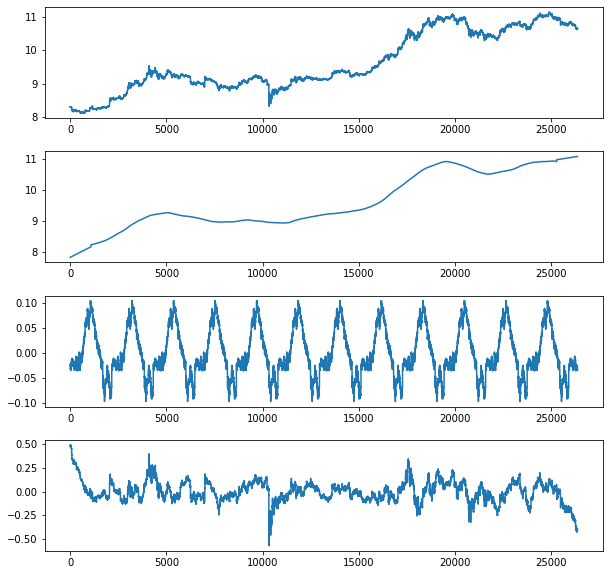

In [16]:
### 2. Bitcoin Price Y
bitcoin_price = bitcoin.close
log_bitcoin_price = np.log(bitcoin_price)
log_bit_decomp = additive_decompose(data = log_bitcoin_price)

In [17]:
### 3. Reshape
# log bitcoin (Y; non-overlapped)
log_bit_day = log_bitcoin_price.values.reshape(int(len(log_bitcoin_price)/24), 24)
print(log_bit_day.shape)

log_bit_week = log_bitcoin_price.values.reshape(int(len(log_bitcoin_price)/168), 168)
print(log_bit_week.shape)

# residuals (Y; non-overlapped)
resid_day = log_bit_decomp.resid.values.reshape(int(len(log_bit_decomp.resid)/24), 24)
print(resid_day.shape)

resid_week = log_bit_decomp.resid.values.reshape(int(len(log_bit_decomp.resid)/168), 168)
print(resid_week.shape)

# Inputs (X; non-overlapped)
all_inputs_norm_day = all_inputs_norm.reshape((all_inputs_norm.shape[0], 1, all_inputs_norm.shape[1]))
print(all_inputs_norm_day.shape)

all_inputs_norm_week = all_inputs_norm.reshape((int(all_inputs_norm.shape[0]/7), 7, all_inputs_norm.shape[1]))
print(all_inputs_norm_week.shape)

# Inputs (X; overlapped; two weeks -> one week)
weeks = 2
all_inputs_norm_week_lap = sliding_windows(pd.DataFrame(all_inputs_norm), n_out = 7*weeks-1)
all_inputs_norm_week_lap = all_inputs_norm_week_lap.values[[i for i in range(0, len(all_inputs_norm_week_lap), 7)], :]
all_inputs_norm_week_lap = all_inputs_norm_week_lap.reshape((len(all_inputs_norm_week_lap), 7*weeks, 8))
print(all_inputs_norm_week_lap.shape) # length is shorter compare to non-overlapped


(1099, 24)
(157, 168)
(1099, 24)
(157, 168)
(1099, 1, 8)
(157, 7, 8)
(156, 14, 8)


## Step 4: Specifiy the length for validating & testing lag and extract trend & seasonal 

In [18]:
# specify length
valid_week = 2
test_week = 1
total_week = valid_week + test_week
day_lag = 7
week_lag = 1

# extract trend & seasonal for validation and testing
trend = log_bit_decomp.trend.tail(7*3*24).values
seas = log_bit_decomp.seas.tail(7*3*24).values
real_val = log_bit_decomp.actual_values.tail(7*3*24).values

## Step 5: LSTM for regression (For model selecting)

In [19]:
class BitcoinDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32)).to("cuda")
        self.y = torch.from_numpy(y.astype(np.float32)).to("cuda")
        self.n_samples = x.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_samples

### Model 1: X non-overlapped; 1 day to 1 day; Y uses residuals training

In [20]:
# data
data1_X = all_inputs_norm_day
data1_Y = resid_day 

# staggering
data1_X = data1_X[:-day_lag]
data1_Y = data1_Y[day_lag:]
print(data1_X.shape, data1_Y.shape)

# split training, validating, and testing
train1_X = data1_X[:-day_lag*total_week]; train1_Y = data1_Y[:-day_lag*total_week]
valid1_X = data1_X[(-day_lag*total_week):(-day_lag*test_week)]; valid1_Y = data1_Y[(-day_lag*total_week):(-day_lag*test_week)]
test1_X = data1_X[-day_lag*test_week:]; test1_Y = data1_Y[-day_lag*test_week:]
print(train1_X.shape, train1_Y.shape, valid1_X.shape, valid1_Y.shape, test1_X.shape, test1_Y.shape)

(1092, 1, 8) (1092, 24)
(1071, 1, 8) (1071, 24) (14, 1, 8) (14, 24) (7, 1, 8) (7, 24)


In [21]:
train_dataloader1 = DataLoader(dataset=BitcoinDataset(train1_X, train1_Y), batch_size=100)
valid_dataloader1 = DataLoader(dataset=BitcoinDataset(valid1_X, valid1_Y), batch_size=100)
test_dataloader1 = DataLoader(dataset=BitcoinDataset(test1_X, test1_Y))

In [22]:
class RNN1(nn.Module):
    def __init__(self, seq_length=train1_X.shape[1], n_features=train1_X.shape[2]):
        super(RNN1, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=500, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2*500, hidden_size=300, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=2*300, hidden_size=100, num_layers=1,
                             bidirectional=True, batch_first=True)                  
        self.dense = nn.Sequential(
            nn.Linear(in_features=2*100, out_features=24),
            nn.CELU()
        )
    def forward(self, inputs):
        output1, (h_n1, c_n1) = self.lstm1(inputs)
        output2, (h_n2, c_n2) = self.lstm2(output1)
        output3, (h_n3, c_n3) = self.lstm3(output2)
        output4 = self.dense(output3[:, -1, :])
        return output4

In [23]:
summary(RNN1(), input_size=(100, 1, 8))

Layer (type:depth-idx)                   Output Shape              Param #
RNN1                                     --                        --
├─LSTM: 1-1                              [100, 1, 1000]            2,040,000
├─LSTM: 1-2                              [100, 1, 600]             3,124,800
├─LSTM: 1-3                              [100, 1, 200]             561,600
├─Sequential: 1-4                        [100, 24]                 --
│    └─Linear: 2-1                       [100, 24]                 4,824
│    └─CELU: 2-2                         [100, 24]                 --
Total params: 5,731,224
Trainable params: 5,731,224
Non-trainable params: 0
Total mult-adds (M): 573.12
Input size (MB): 0.00
Forward/backward pass size (MB): 1.46
Params size (MB): 22.92
Estimated Total Size (MB): 24.39

In [24]:
model1 = RNN1().to(device="cuda")

In [25]:
writer1 = SummaryWriter('.\\torch logs\\logs1')
dataiter1 = iter(train_dataloader1)
training_data1, labels1 = dataiter1.next()
writer1.add_graph(model1, training_data1)
writer1.close()

In [26]:
def train1(train_loader, val_loader, model, loss_fn, optimizer, epochs, visualize=False):
    for epoch in range(1, epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for i, (train_data, train_target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            train_predict = model(train_data)
            t_loss = loss_fn(train_predict, train_target)
            t_loss.backward()
            optimizer.step()
            train_loss += t_loss.item()*train_data.shape[0]
        if visualize and (epoch % 10 == 0):
            # ...log the running loss
            writer1.add_scalar("training loss",
                                train_loss/10,
                                epoch)

        model.eval()
        with torch.no_grad():
            for j, (val_data, val_target) in enumerate(val_loader, 1): # tqdm(val_loader)
                val_predict = model(val_data)
                v_loss = loss_fn(val_predict, val_target)
                valid_loss += v_loss.item()*val_data.size(0)
            if visualize and (j % 10 == 0):
                # ...log the running loss
                writer1.add_scalar("validation loss",
                                    valid_loss/10,
                                    epoch)
        
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        if epoch % 10 == 0:
            print(f'running epoch: {epoch}/{epochs}')
            print(f"epoch: {epoch}, training loss = {train_loss:.4f}, val loss = {valid_loss:.4f}")

In [27]:
criterion1 = nn.MSELoss().to(device="cuda")
optimizer1 = torch.optim.Adam(model1.parameters())
train1(train_loader=train_dataloader1, val_loader=valid_dataloader1, model=model1,
       loss_fn=criterion1, optimizer=optimizer1, epochs=250, visualize=True)

running epoch: 10/250
epoch: 10, training loss = 0.0090, val loss = 0.0456
running epoch: 20/250
epoch: 20, training loss = 0.0093, val loss = 0.0422
running epoch: 30/250
epoch: 30, training loss = 0.0099, val loss = 0.0458
running epoch: 40/250
epoch: 40, training loss = 0.0102, val loss = 0.0759
running epoch: 50/250
epoch: 50, training loss = 0.0086, val loss = 0.0313
running epoch: 60/250
epoch: 60, training loss = 0.0084, val loss = 0.0285
running epoch: 70/250
epoch: 70, training loss = 0.0081, val loss = 0.0333
running epoch: 80/250
epoch: 80, training loss = 0.0078, val loss = 0.0369
running epoch: 90/250
epoch: 90, training loss = 0.0077, val loss = 0.0286
running epoch: 100/250
epoch: 100, training loss = 0.0077, val loss = 0.0222
running epoch: 110/250
epoch: 110, training loss = 0.0073, val loss = 0.0261
running epoch: 120/250
epoch: 120, training loss = 0.0069, val loss = 0.0280
running epoch: 130/250
epoch: 130, training loss = 0.0068, val loss = 0.0233
running epoch: 14

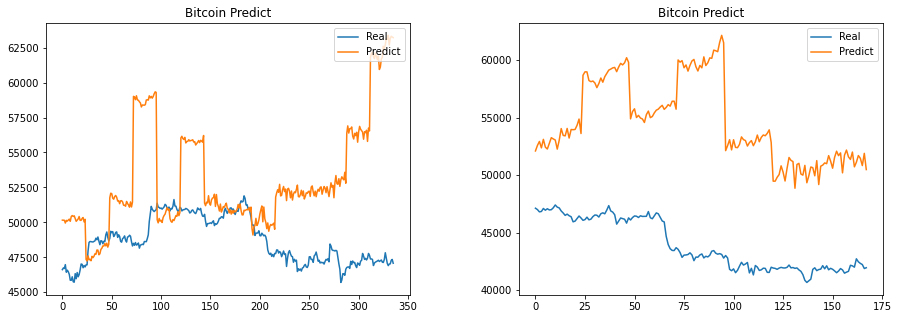

In [28]:
# Result for validation and testing
result1 = np.exp(np.concatenate((model1(torch.from_numpy(valid1_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy(), 
                                 model1(torch.from_numpy(test1_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy()), axis=0) \
                                      + trend + seas)

plt.subplots(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

# plot validation
plt.subplot(1, 2, 1)
plt.plot(np.exp(real_val[0:7*24*2]))
plt.plot(result1[0:7*24*2])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

# plot testing
plt.subplot(1, 2, 2)
plt.plot(np.exp(real_val[7*24*2:7*24*3]))
plt.plot(result1[7*24*2:7*24*3])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

### Model 2: X non-overlapped; 1 week to 1 week; Y uses residuals training

In [29]:
# data
data2_X = all_inputs_norm_week
data2_Y = resid_week

# staggering
data2_X = data2_X[:-week_lag]
data2_Y = data2_Y[week_lag:]
print(data2_X.shape, data2_Y.shape)

# split training, validating, and testing
train2_X = data2_X[:-week_lag*total_week]; train2_Y = data2_Y[:-week_lag*total_week]
valid2_X = data2_X[(-week_lag*total_week):(-week_lag*test_week)]; valid2_Y = data2_Y[(-week_lag*total_week):(-week_lag*test_week)]
test2_X = data2_X[-week_lag*test_week:]; test2_Y = data2_Y[-week_lag*test_week:]
print(train2_X.shape, train2_Y.shape, valid2_X.shape, valid2_Y.shape, test2_X.shape, test2_Y.shape)

(156, 7, 8) (156, 168)
(153, 7, 8) (153, 168) (2, 7, 8) (2, 168) (1, 7, 8) (1, 168)


In [30]:
train_dataloader2 = DataLoader(dataset=BitcoinDataset(train2_X, train2_Y), batch_size=30)
valid_dataloader2 = DataLoader(dataset=BitcoinDataset(valid2_X, valid2_Y), batch_size=30)
test_dataloader2 = DataLoader(dataset=BitcoinDataset(test2_X, test2_Y))

In [31]:
class RNN2(nn.Module):
    def __init__(self, seq_length=train2_X.shape[1], n_features=train2_X.shape[2]):
        super(RNN2, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=500, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2*500, hidden_size=300, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.dense = nn.Sequential(
            nn.Linear(in_features=600, out_features=168),
            nn.CELU()
        )
    def forward(self, inputs):
        output1, (h_n1, c_n1) = self.lstm1(inputs)
        output2, (h_n2, c_n2) = self.lstm2(output1)
        output3 = self.dense(output2[:, -1, :])
        return output3

In [32]:
summary(RNN2(), input_size=(30, 7, 8))

Layer (type:depth-idx)                   Output Shape              Param #
RNN2                                     --                        --
├─LSTM: 1-1                              [30, 7, 1000]             2,040,000
├─LSTM: 1-2                              [30, 7, 600]              3,124,800
├─Sequential: 1-3                        [30, 168]                 --
│    └─Linear: 2-1                       [30, 168]                 100,968
│    └─CELU: 2-2                         [30, 168]                 --
Total params: 5,265,768
Trainable params: 5,265,768
Non-trainable params: 0
Total mult-adds (G): 1.09
Input size (MB): 0.01
Forward/backward pass size (MB): 2.73
Params size (MB): 21.06
Estimated Total Size (MB): 23.80

In [33]:
model2 = RNN2().to(device="cuda")

In [34]:
writer2 = SummaryWriter('.\\torch logs\\logs2')
dataiter2 = iter(train_dataloader2)
training_data2, labels2 = dataiter2.next()
writer2.add_graph(model2, training_data2)
writer2.close()

In [35]:
def train2(train_loader, val_loader, model, loss_fn, optimizer, epochs, visualize=False):
    for epoch in range(1, epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for i, (train_data, train_target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            train_predict = model(train_data)
            t_loss = loss_fn(train_predict, train_target)
            t_loss.backward()
            optimizer.step()
            train_loss += t_loss.item()*train_data.shape[0]
        if visualize and (epoch % 10 == 0):
            # ...log the running loss
            writer2.add_scalar("training loss",
                                train_loss/10,
                                epoch)

        model.eval()
        with torch.no_grad():
            for j, (val_data, val_target) in enumerate(val_loader, 1): # tqdm(val_loader)
                val_predict = model(val_data)
                v_loss = loss_fn(val_predict, val_target)
                valid_loss += v_loss.item()*val_data.size(0)
            if visualize and (epoch % 10 == 0):
                # ...log the running loss
                writer2.add_scalar("validation loss",
                                    valid_loss/10,
                                    epoch)
        
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        if epoch % 10 == 0:
            print(f'running epoch: {epoch}/{epochs}')
            print(f"epoch: {epoch}, training loss = {train_loss:.4f}, val loss = {valid_loss:.4f}")

In [36]:
criterion2 = nn.MSELoss().to(device="cuda")
optimizer2 = torch.optim.Adam(model2.parameters())
train2(train_loader=train_dataloader2, val_loader=valid_dataloader2, model=model2,
       loss_fn=criterion2, optimizer=optimizer2, epochs=200, visualize=True)

running epoch: 10/200
epoch: 10, training loss = 0.0096, val loss = 0.0469
running epoch: 20/200
epoch: 20, training loss = 0.0099, val loss = 0.0484
running epoch: 30/200
epoch: 30, training loss = 0.0080, val loss = 0.0195
running epoch: 40/200
epoch: 40, training loss = 0.0081, val loss = 0.0204
running epoch: 50/200
epoch: 50, training loss = 0.0074, val loss = 0.0274
running epoch: 60/200
epoch: 60, training loss = 0.0072, val loss = 0.0243
running epoch: 70/200
epoch: 70, training loss = 0.0076, val loss = 0.0501
running epoch: 80/200
epoch: 80, training loss = 0.0109, val loss = 0.0335
running epoch: 90/200
epoch: 90, training loss = 0.0061, val loss = 0.0287
running epoch: 100/200
epoch: 100, training loss = 0.0051, val loss = 0.0271
running epoch: 110/200
epoch: 110, training loss = 0.0045, val loss = 0.0277
running epoch: 120/200
epoch: 120, training loss = 0.0047, val loss = 0.0248
running epoch: 130/200
epoch: 130, training loss = 0.0036, val loss = 0.0259
running epoch: 14

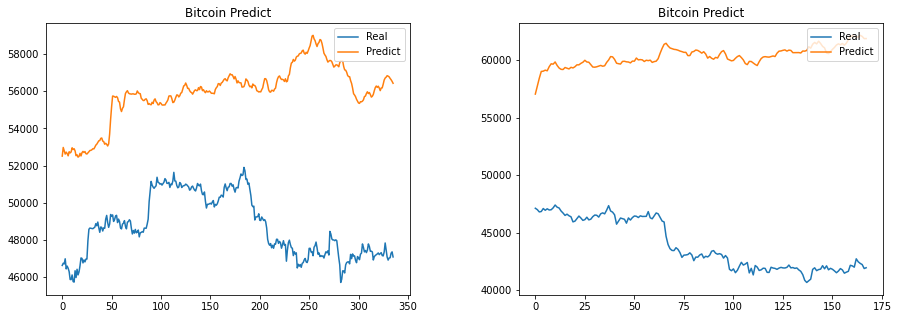

In [37]:
# Result for validation and testing
result2 = np.exp(np.concatenate((model2(torch.from_numpy(valid2_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy(), 
                                 model2(torch.from_numpy(test2_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy()), axis = 0) \
                                      + trend + seas)
# smooth result
windows = 4
result2_smooth = pd.DataFrame(result2).rolling(window = windows).mean()
result2_smooth[0:windows-1] = pd.DataFrame(result2[0:windows-1])
result2_smooth = result2_smooth.values

plt.subplots(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

# plot validation
plt.subplot(1, 2, 1)
plt.plot(np.exp(real_val[0:7*24*2]))
plt.plot(result2_smooth[0:7*24*2])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

# plot testing
plt.subplot(1, 2, 2)
plt.plot(np.exp(real_val[7*24*2:7*24*3]))
plt.plot(result2_smooth[7*24*2:7*24*3])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

### Model 3: X overlapped; 2 weeks to 1 week; Y uses residuals training

In [38]:
# data
data3_X = all_inputs_norm_week_lap
data3_Y = resid_week

# staggering
data3_X = data3_X[:-1]
data3_Y = data3_Y[2:]
print(data3_X.shape, data3_Y.shape)

# split training, validating, and testing
train3_X = data3_X[:-week_lag*total_week]; train3_Y = data3_Y[:-week_lag*total_week]
valid3_X = data3_X[(-week_lag*total_week):(-week_lag*test_week)]; valid3_Y = data3_Y[(-week_lag*total_week):(-week_lag*test_week)]
test3_X = data3_X[-week_lag*test_week:]; test3_Y = data3_Y[-week_lag*test_week:]
print(train3_X.shape, train3_Y.shape, valid3_X.shape, valid3_Y.shape, test3_X.shape, test3_Y.shape)


(155, 14, 8) (155, 168)
(152, 14, 8) (152, 168) (2, 14, 8) (2, 168) (1, 14, 8) (1, 168)


In [39]:
train_dataloader3 = DataLoader(dataset=BitcoinDataset(train3_X, train3_Y), batch_size=50)
valid_dataloader3 = DataLoader(dataset=BitcoinDataset(valid3_X, valid3_Y), batch_size=50)
test_dataloader3 = DataLoader(dataset=BitcoinDataset(test3_X, test3_Y))

In [40]:
for data, label in train_dataloader3:
    print(type(data))
    print(data.shape, label.shape)
    print(data.size(), label.size())
    print(data.is_cuda, label.is_cuda)
    break
print(len(train_dataloader3.dataset))

<class 'torch.Tensor'>
torch.Size([50, 14, 8]) torch.Size([50, 168])
torch.Size([50, 14, 8]) torch.Size([50, 168])
True True
152


In [41]:
class RNN3(nn.Module):
    def __init__(self, seq_length=train3_X.shape[1], n_features=train3_X.shape[2]):
        super(RNN3, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=300, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2*300, hidden_size=100, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.gap2d = nn.AdaptiveAvgPool2d(output_size=(1, 200))
        self.dense = nn.Sequential(
            nn.Linear(in_features=2*100, out_features=300),
            nn.Sigmoid(),
            nn.Linear(in_features=300, out_features=168)
        )
    def forward(self, inputs):
        output1, (h_n1, c_n1) = self.lstm1(inputs)
        output2, (h_n2, c_n2) = self.lstm2(output1)
        output3 = self.gap2d(output2).view(-1, 200)
        output4 = self.dense(output3)
        return output4

In [42]:
summary(RNN3(), input_size=(50, 14, 8))

Layer (type:depth-idx)                   Output Shape              Param #
RNN3                                     --                        --
├─LSTM: 1-1                              [50, 14, 600]             744,000
├─LSTM: 1-2                              [50, 14, 200]             561,600
├─AdaptiveAvgPool2d: 1-3                 [50, 1, 200]              --
├─Sequential: 1-4                        [50, 168]                 --
│    └─Linear: 2-1                       [50, 300]                 60,300
│    └─Sigmoid: 2-2                      [50, 300]                 --
│    └─Linear: 2-3                       [50, 168]                 50,568
Total params: 1,416,468
Trainable params: 1,416,468
Non-trainable params: 0
Total mult-adds (M): 919.46
Input size (MB): 0.02
Forward/backward pass size (MB): 4.67
Params size (MB): 5.67
Estimated Total Size (MB): 10.36

In [43]:
model3 = RNN3().to(device="cuda")

In [44]:
writer3 = SummaryWriter('.\\torch logs\\logs3')
dataiter3 = iter(train_dataloader3)
training_data3, labels3 = dataiter3.next()
writer3.add_graph(model3, training_data3)
writer3.close()

In [45]:
def train3(train_loader, val_loader, model, loss_fn, optimizer, epochs, visualize=False):
    for epoch in range(1, epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for i, (train_data, train_target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            train_predict = model(train_data)
            t_loss = loss_fn(train_predict, train_target)
            t_loss.backward()
            optimizer.step()
            train_loss += t_loss.item()*train_data.shape[0]
        if visualize and (epoch % 10 == 0):
            # ...log the running loss
            writer3.add_scalar("training loss",
                                train_loss/10,
                                epoch)

        model.eval()
        with torch.no_grad():
            for j, (val_data, val_target) in enumerate(val_loader, 1): # tqdm(val_loader)
                val_predict = model(val_data)
                v_loss = loss_fn(val_predict, val_target)
                valid_loss += v_loss.item()*val_data.size(0)
            if visualize and (epoch % 10 == 0):
                # ...log the running loss
                writer3.add_scalar("validation loss",
                                    valid_loss/10,
                                    epoch)
        
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        if epoch % 10 == 0:
            print(f'running epoch: {epoch}/{epochs}')
            print(f"epoch: {epoch}, training loss = {train_loss:.4f}, val loss = {valid_loss:.4f}")

In [46]:
criterion3 = nn.MSELoss().to(device="cuda")
optimizer3 = torch.optim.Adam(model3.parameters())
train3(train_loader=train_dataloader3, val_loader=valid_dataloader3, model=model3,
       loss_fn=criterion3, optimizer=optimizer3, epochs=200, visualize=True)

running epoch: 10/200
epoch: 10, training loss = 0.0105, val loss = 0.0125
running epoch: 20/200
epoch: 20, training loss = 0.0100, val loss = 0.0129
running epoch: 30/200
epoch: 30, training loss = 0.0092, val loss = 0.0340
running epoch: 40/200
epoch: 40, training loss = 0.0102, val loss = 0.0025
running epoch: 50/200
epoch: 50, training loss = 0.0081, val loss = 0.0182
running epoch: 60/200
epoch: 60, training loss = 0.0069, val loss = 0.0413
running epoch: 70/200
epoch: 70, training loss = 0.0074, val loss = 0.0148
running epoch: 80/200
epoch: 80, training loss = 0.0108, val loss = 0.0183
running epoch: 90/200
epoch: 90, training loss = 0.0069, val loss = 0.0304
running epoch: 100/200
epoch: 100, training loss = 0.0063, val loss = 0.0263
running epoch: 110/200
epoch: 110, training loss = 0.0063, val loss = 0.0310
running epoch: 120/200
epoch: 120, training loss = 0.0059, val loss = 0.0320
running epoch: 130/200
epoch: 130, training loss = 0.0057, val loss = 0.0300
running epoch: 14

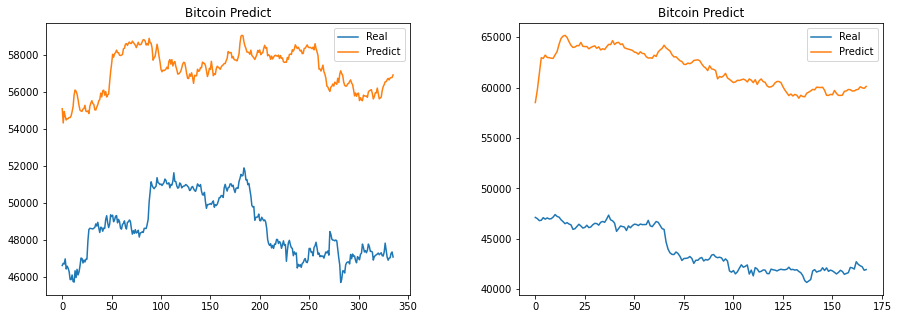

In [47]:
# Result for validation and testing
result3 = np.exp(np.concatenate((model3(torch.from_numpy(valid3_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy(), 
                                 model3(torch.from_numpy(test3_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy()), axis=0) \
                                      + trend + seas)

# smooth result
windows = 4
result3_smooth = pd.DataFrame(result3).rolling(window = windows).mean()
result3_smooth[0:windows-1] = pd.DataFrame(result3[0:windows-1])
result3_smooth = result3_smooth.values

plt.subplots(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

# plot validation
plt.subplot(1, 2, 1)
plt.plot(np.exp(real_val[0:7*24*2]))
plt.plot(result3_smooth[0:7*24*2])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

# plot testing
plt.subplot(1, 2, 2)
plt.plot(np.exp(real_val[7*24*2:7*24*3]))
plt.plot(result3_smooth[7*24*2:7*24*3])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

### Model 4: X non-overlapped; 1 day to 1 day; Y uses log price

In [48]:
# data
data4_X = all_inputs_norm_day
data4_Y = log_bit_day 

# staggering
data4_X = data4_X[:-day_lag]
data4_Y = data4_Y[day_lag:]
print(data4_X.shape, data4_Y.shape)

# split training, validating, and testing
train4_X = data4_X[:-day_lag*total_week]; train4_Y = data4_Y[:-day_lag*total_week]
valid4_X = data4_X[(-day_lag*total_week):(-day_lag*test_week)]; valid4_Y = data4_Y[(-day_lag*total_week):(-day_lag*test_week)]
test4_X = data4_X[-day_lag*test_week:]; test4_Y = data4_Y[-day_lag*test_week:]
print(train4_X.shape, train4_Y.shape, valid4_X.shape, valid4_Y.shape, test4_X.shape, test4_Y.shape)

(1092, 1, 8) (1092, 24)
(1071, 1, 8) (1071, 24) (14, 1, 8) (14, 24) (7, 1, 8) (7, 24)


In [49]:
train_dataloader4 = DataLoader(dataset=BitcoinDataset(train4_X, train4_Y), batch_size=100)
valid_dataloader4 = DataLoader(dataset=BitcoinDataset(valid4_X, valid4_Y), batch_size=100)
test_dataloader4 = DataLoader(dataset=BitcoinDataset(test4_X, test4_Y))

In [50]:
class RNN4(nn.Module):
    def __init__(self, seq_length=train4_X.shape[1], n_features=train4_X.shape[2]):
        super(RNN4, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=300, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2*300, hidden_size=100, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.dense = nn.Sequential(
            nn.Linear(in_features=2*100, out_features=24),
            nn.CELU()
        )
    def forward(self, inputs):
        output1, (h_n1, c_n1) = self.lstm1(inputs)
        output2, (h_n2, c_n2) = self.lstm2(output1)
        output3 = self.dense(output2[:, -1, :])
        return output3

In [51]:
summary(RNN4(), input_size=(100, 1, 8))

Layer (type:depth-idx)                   Output Shape              Param #
RNN4                                     --                        --
├─LSTM: 1-1                              [100, 1, 600]             744,000
├─LSTM: 1-2                              [100, 1, 200]             561,600
├─Sequential: 1-3                        [100, 24]                 --
│    └─Linear: 2-1                       [100, 24]                 4,824
│    └─CELU: 2-2                         [100, 24]                 --
Total params: 1,310,424
Trainable params: 1,310,424
Non-trainable params: 0
Total mult-adds (M): 131.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.66
Params size (MB): 5.24
Estimated Total Size (MB): 5.90

In [52]:
model4 = RNN4().to(device="cuda")

In [53]:
writer4 = SummaryWriter('.\\torch logs\\logs4')
dataiter4 = iter(train_dataloader4)
training_data4, labels4 = dataiter4.next()
writer4.add_graph(model4, training_data4)
writer4.close()

In [54]:
def train4(train_loader, val_loader, model, loss_fn, optimizer, epochs, visualize=False):
    for epoch in range(1, epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for i, (train_data, train_target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            train_predict = model(train_data)
            t_loss = loss_fn(train_predict, train_target)
            t_loss.backward()
            optimizer.step()
            train_loss += t_loss.item()*train_data.shape[0]
        if visualize and (epoch % 10 == 0):
            # ...log the running loss
            writer4.add_scalar("training loss",
                                train_loss/10,
                                epoch)

        model.eval()
        with torch.no_grad():
            for j, (val_data, val_target) in enumerate(val_loader, 1): # tqdm(val_loader)
                val_predict = model(val_data)
                v_loss = loss_fn(val_predict, val_target)
                valid_loss += v_loss.item()*val_data.size(0)
            if visualize and (epoch % 10 == 0):
                # ...log the running loss
                writer4.add_scalar("validation loss",
                                    valid_loss/10,
                                    epoch)
        
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        if epoch % 10 == 0:
            print(f'running epoch: {epoch}/{epochs}')
            print(f"epoch: {epoch}, training loss = {train_loss:.4f}, val loss = {valid_loss:.4f}")

In [55]:
criterion4 = nn.MSELoss().to(device="cuda")
optimizer4 = torch.optim.Adam(model4.parameters())
train4(train_loader=train_dataloader4, val_loader=valid_dataloader4, model=model4,
       loss_fn=criterion4, optimizer=optimizer4, epochs=350, visualize=True)

running epoch: 10/350
epoch: 10, training loss = 0.1024, val loss = 0.2746
running epoch: 20/350
epoch: 20, training loss = 0.0864, val loss = 0.1939
running epoch: 30/350
epoch: 30, training loss = 0.0808, val loss = 0.1604
running epoch: 40/350
epoch: 40, training loss = 0.0757, val loss = 0.1353
running epoch: 50/350
epoch: 50, training loss = 0.0712, val loss = 0.1158
running epoch: 60/350
epoch: 60, training loss = 0.0671, val loss = 0.1001
running epoch: 70/350
epoch: 70, training loss = 0.0636, val loss = 0.0876
running epoch: 80/350
epoch: 80, training loss = 0.0605, val loss = 0.0775
running epoch: 90/350
epoch: 90, training loss = 0.0578, val loss = 0.0693
running epoch: 100/350
epoch: 100, training loss = 0.0554, val loss = 0.0624
running epoch: 110/350
epoch: 110, training loss = 0.0533, val loss = 0.0562
running epoch: 120/350
epoch: 120, training loss = 0.0512, val loss = 0.0493
running epoch: 130/350
epoch: 130, training loss = 0.0490, val loss = 0.0414
running epoch: 14

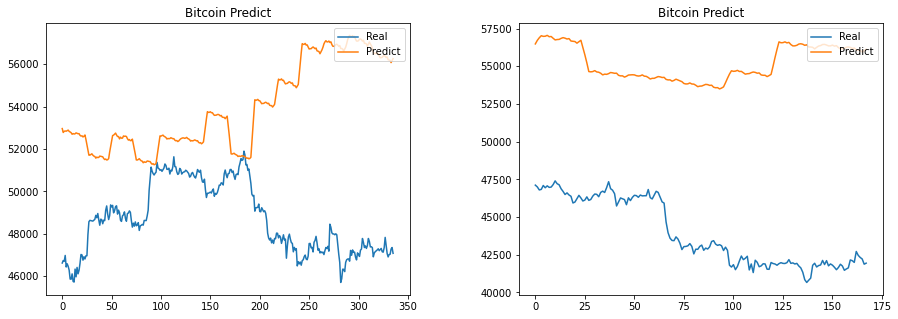

In [56]:
# Result for validation and testing
result4 = np.exp(np.concatenate((model4(torch.from_numpy(valid4_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy(), 
                                 model4(torch.from_numpy(test4_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy()), axis = 0))

# smooth result
windows = 4
result4_smooth = pd.DataFrame(result4).rolling(window = windows).mean()
result4_smooth[0:windows-1] = pd.DataFrame(result4[0:windows-1])
result4_smooth = result4_smooth.values

plt.subplots(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

# plot validation
plt.subplot(1, 2, 1)
plt.plot(np.exp(real_val[0:7*24*2]))
plt.plot(result4_smooth[0:7*24*2])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

# plot testing
plt.subplot(1, 2, 2)
plt.plot(np.exp(real_val[7*24*2:7*24*3]))
plt.plot(result4_smooth[7*24*2:7*24*3])
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

## Step 6: LSTM for regression (For real testing)
- After you have selected the best model above, then you can do slight adjustment for the model (Under is the example using model 3)
- Note: Don't be too harsh to validation result, because there will be a suprise in real predicting

In [57]:
# data
real_predict_X = all_inputs_norm_week_lap
real_predict_Y = resid_week

# staggering
real_predict_X = real_predict_X[:-1]
real_predict_Y = real_predict_Y[2:]
print(real_predict_X.shape, real_predict_Y.shape)

# split training, validating, and testing
training_X = real_predict_X[:-1]; training_Y = real_predict_Y[:-1]
validation_X = real_predict_X[-1:]; validation_Y = real_predict_Y[-1:]
print(training_X.shape, training_Y.shape, validation_X.shape, validation_Y.shape)

(155, 14, 8) (155, 168)
(154, 14, 8) (154, 168) (1, 14, 8) (1, 168)


In [58]:
train_dataloader6 = DataLoader(dataset=BitcoinDataset(training_X, training_Y), batch_size=50)
valid_dataloader6 = DataLoader(dataset=BitcoinDataset(validation_X, validation_Y), batch_size=50)

In [59]:
for i, (data, label) in enumerate(train_dataloader6):
    print(type(data))
    print(data.shape, label.shape)
    print(data.is_cuda, label.is_cuda)
    break
print(len(train_dataloader6.dataset))
print(f"{len(train_dataloader6)} 個 batch")

<class 'torch.Tensor'>
torch.Size([50, 14, 8]) torch.Size([50, 168])
True True
154
4 個 batch


In [60]:
class Prediction(nn.Module):
    def __init__(self, seq_length=training_X.shape[1], n_features=training_X.shape[2]):
        super(Prediction, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=300, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=2*300, hidden_size=100, num_layers=1,
                             bidirectional=True, batch_first=True)
        self.gap2d = nn.AdaptiveAvgPool2d(output_size=(1, 200))
        self.dense = nn.Sequential(
            nn.Linear(in_features=2*100, out_features=300),
            nn.Sigmoid(),
            nn.Linear(in_features=300, out_features=168)
        )
    def forward(self, inputs):
        output1, (h_n1, c_n1) = self.lstm1(inputs)
        output2, (h_n2, c_n2) = self.lstm2(output1)
        output3 = self.gap2d(output2).view(-1, 200)
        output4 = self.dense(output3)
        return output4

In [61]:
summary(Prediction(), input_size=(50, 14, 8))

Layer (type:depth-idx)                   Output Shape              Param #
Prediction                               --                        --
├─LSTM: 1-1                              [50, 14, 600]             744,000
├─LSTM: 1-2                              [50, 14, 200]             561,600
├─AdaptiveAvgPool2d: 1-3                 [50, 1, 200]              --
├─Sequential: 1-4                        [50, 168]                 --
│    └─Linear: 2-1                       [50, 300]                 60,300
│    └─Sigmoid: 2-2                      [50, 300]                 --
│    └─Linear: 2-3                       [50, 168]                 50,568
Total params: 1,416,468
Trainable params: 1,416,468
Non-trainable params: 0
Total mult-adds (M): 919.46
Input size (MB): 0.02
Forward/backward pass size (MB): 4.67
Params size (MB): 5.67
Estimated Total Size (MB): 10.36

In [62]:
prediction = Prediction().to(device="cuda")

In [63]:
writer6 = SummaryWriter('.\\torch logs\\logs6')
dataiter6 = iter(train_dataloader6)
training_data6, labels6 = dataiter6.next()
writer6.add_graph(prediction, training_data6)
writer6.close()

In [64]:
def train6(train_loader, val_loader, model, loss_fn, optimizer, epochs, visualize=False):
    for epoch in range(1, epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for i, (train_data, train_target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            train_predict = model(train_data)
            t_loss = loss_fn(train_predict, train_target)
            t_loss.backward()
            optimizer.step()
            train_loss += t_loss.item()*train_data.shape[0]
        if visualize and (epoch % 10 == 0):
            # ...log the running loss
            writer6.add_scalar("training loss",
                                train_loss/10,
                                epoch)

        model.eval()
        with torch.no_grad():
            for j, (val_data, val_target) in enumerate(val_loader, 1): # tqdm(val_loader)
                val_predict = model(val_data)
                v_loss = loss_fn(val_predict, val_target)
                valid_loss += v_loss.item()*val_data.size(0)
            if visualize and (epoch % 10 == 0):
                # ...log the running loss
                writer6.add_scalar("validation loss",
                                    valid_loss/10,
                                    epoch)
        
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        if epoch % 10 == 0:
            print(f'running epoch: {epoch}/{epochs}')
            print(f"epoch: {epoch}, training loss = {train_loss:.4f}, val loss = {valid_loss:.4f}")

In [65]:
criterion6 = nn.MSELoss().to(device="cuda")
optimizer6 = torch.optim.Adam(prediction.parameters())
train6(train_loader=train_dataloader6, val_loader=valid_dataloader6, model=prediction,
       loss_fn=criterion6, optimizer=optimizer6, epochs=200, visualize=True)

running epoch: 10/200
epoch: 10, training loss = 0.0110, val loss = 0.0354
running epoch: 20/200
epoch: 20, training loss = 0.0108, val loss = 0.0366
running epoch: 30/200
epoch: 30, training loss = 0.0103, val loss = 0.0284
running epoch: 40/200
epoch: 40, training loss = 0.0119, val loss = 0.0209
running epoch: 50/200
epoch: 50, training loss = 0.0097, val loss = 0.0505
running epoch: 60/200
epoch: 60, training loss = 0.0082, val loss = 0.0185
running epoch: 70/200
epoch: 70, training loss = 0.0073, val loss = 0.0127
running epoch: 80/200
epoch: 80, training loss = 0.0065, val loss = 0.0125
running epoch: 90/200
epoch: 90, training loss = 0.0064, val loss = 0.0057
running epoch: 100/200
epoch: 100, training loss = 0.0078, val loss = 0.0183
running epoch: 110/200
epoch: 110, training loss = 0.0056, val loss = 0.0162
running epoch: 120/200
epoch: 120, training loss = 0.0046, val loss = 0.0233
running epoch: 130/200
epoch: 130, training loss = 0.0055, val loss = 0.0297
running epoch: 14

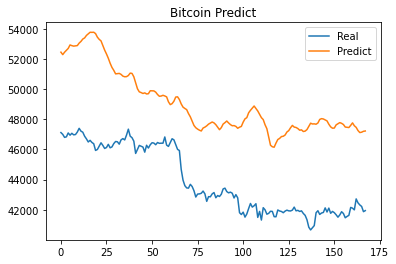

In [66]:
valid_trend = log_bit_decomp.trend.tail(7*1*24).values
valid_seas = log_bit_decomp.seas.tail(7*1*24).values
valid_real_val = log_bit_decomp.actual_values.tail(7*1*24).values

# Result for validation 
valid_result = np.exp(prediction(torch.from_numpy(validation_X.astype(np.float32)).to("cuda")).flatten().cpu().detach().numpy() + \
     valid_trend + valid_seas)

# smooth result
windows = 4
valid_smooth = pd.DataFrame(valid_result).rolling(window = windows).mean()
valid_smooth[0:windows-1] = pd.DataFrame(valid_result[0:windows-1])
valid_smooth = valid_smooth.values

# plot validation
plt.plot(np.exp(valid_real_val))
plt.plot(valid_smooth)
plt.title('Bitcoin Predict')
plt.legend(['Real', 'Predict'], loc='upper right')

未來一個禮拜價格最低可來到: 35085.302136076454
未來一個禮拜價格最高可來到: 41689.19270120771


array([[41660.69      ],
       [41316.46153904],
       [41327.14095951],
       [41510.2823431 ],
       [41525.06660489],
       [41689.19270121],
       [41589.94240377],
       [41588.73700477],
       [41578.30986366],
       [41456.80591751],
       [41441.06484716],
       [41381.10122471],
       [41371.70957858],
       [41216.85247399],
       [41219.73871484],
       [41084.91043064],
       [40924.82511903],
       [40804.64358381],
       [40732.86566878],
       [40689.54429355],
       [40534.09138388],
       [40465.56034911],
       [40415.08915575],
       [40088.44668749],
       [39755.99115815],
       [39494.13838744],
       [39167.47517596],
       [38779.04047267],
       [38497.0389382 ],
       [38320.44827845],
       [38137.35438993],
       [38213.11108126],
       [38189.21086118],
       [38064.89734507],
       [37890.89435238],
       [37745.35944673],
       [37721.6798962 ],
       [37769.79807959],
       [37916.5528096 ],
       [37912.49562498],


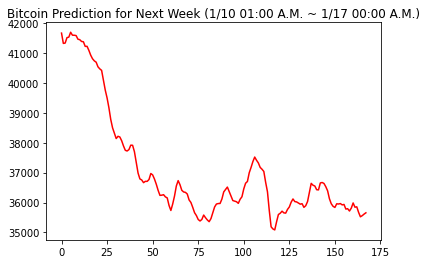

In [67]:
# Here you can get the output for the real future bitcoin price prediction using Predict_for_Teacher function (Not run)
# Note that data size is correct
# Check if the first prediction is suitable
data = data3_X[-1].reshape(1, 14, 8)
Predict = prediction(torch.from_numpy(data.astype(np.float32)).to("cuda")).cpu().detach().numpy()
Predict_for_Teacher(predict = Predict, peek_price = 41660.69)

## Step 7: Classification

### Clustering for classification label

In [68]:
# Combine new predicted data to do ICA together
ica_data = np.concatenate((resid_week.T, np.array(Predict).T), axis = 1)

# ICA decomposition
ica = FastICA(n_components = 7, max_iter = 100000, random_state = 2021)
ica_result = ica.fit_transform(ica_data)

Text(0, 0.5, 'Fuzzy partition coefficient')

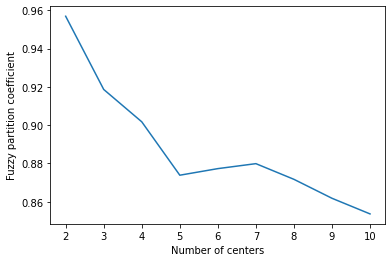

In [69]:
# Leave predicted data's ica mixing
cmeans_train = ica.mixing_.T[:, 0:ica.mixing_.shape[0]-1]
cmeans_predict = ica.mixing_.T[:, ica.mixing_.shape[0]-1]

# Cmeans for validation
fpcs = []

for i in range(2, 11, 1):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        cmeans_train, i, 1.2, error = 0.005, maxiter = 1000, seed = 2021)

    # Store fpc values for later
    fpcs.append(fpc)
    
fig, ax = plt.subplots()
ax.plot(np.r_[2:11], fpcs)
ax.set_xlabel("Number of centers")
ax.set_ylabel("Fuzzy partition coefficient")

In [70]:
# Train Cmeans
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(cmeans_train, c = 5, m = 1.2, error=0.005, maxiter = 1000, seed = 2021)

# Count numbers for each group
cmeans_label = u.argmax(axis = 0)
unique, counts = np.unique(cmeans_label, return_counts = True)
dict(zip(unique, counts))

{0: 31, 1: 35, 2: 21, 3: 15, 4: 55}

### Neural network for classification

In [71]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]
# data (ICA coefficients)
X = cmeans_train.T
# Y = to_categorical(cmeans_label, 5)
Y = cmeans_label

# train & test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2021)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(125, 7) (125,) (32, 7) (32,)


In [72]:
class classifier(nn.Module):
    def __init__(self) -> None:
        super(classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=X_train.shape[1], out_features=15),
            nn.ReLU(),
            nn.Linear(in_features=15, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=5),
            nn.Softmax()
        )
    def forward(self, inputs):
        return self.network(inputs)

In [73]:
def train_classifier(train_loader, val_loader, model, loss_fn, optimizer, epochs):
    for epoch in range(1, epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for i, (train_data, train_target) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            train_predict = model(train_data)
            t_loss = loss_fn(train_predict, train_target.long())
            t_loss.backward()
            optimizer.step()
            train_loss += t_loss.item()*train_data.shape[0]
        
        model.eval()
        with torch.no_grad():
            for j, (val_data, val_target) in enumerate(val_loader, 1): # tqdm(val_loader)
                val_predict = model(val_data)
                v_loss = loss_fn(val_predict, val_target.long())
                valid_loss += v_loss.item()*val_data.size(0)
            
        train_loss /= len(train_loader.dataset)
        valid_loss /= len(val_loader.dataset)
        if epoch % 10 == 0:
            print(f'running epoch: {epoch}/{epochs}')
            print(f"epoch: {epoch}, training loss = {train_loss:.4f}, val loss = {valid_loss:.4f}")

In [74]:
train_dataloader7 = DataLoader(dataset=BitcoinDataset(X_train, Y_train), batch_size=35)
valid_dataloader7 = DataLoader(dataset=BitcoinDataset(X_test, Y_test))
classification = classifier().to(device="cuda")

In [75]:
criterion7 = nn.CrossEntropyLoss().to(device="cuda")
optimizer7 = torch.optim.Adam(classification.parameters())
train_classifier(train_loader=train_dataloader7, val_loader=valid_dataloader7, model=classification, loss_fn=criterion7, optimizer=optimizer7, epochs=120)

e:\Master\Big Data Analysis\Bitcoin_venv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


running epoch: 10/120
epoch: 10, training loss = 1.5957, val loss = 1.5809
running epoch: 20/120
epoch: 20, training loss = 1.5882, val loss = 1.5716
running epoch: 30/120
epoch: 30, training loss = 1.5774, val loss = 1.5594
running epoch: 40/120
epoch: 40, training loss = 1.5589, val loss = 1.5401
running epoch: 50/120
epoch: 50, training loss = 1.5284, val loss = 1.5089
running epoch: 60/120
epoch: 60, training loss = 1.4889, val loss = 1.4656
running epoch: 70/120
epoch: 70, training loss = 1.4422, val loss = 1.4115
running epoch: 80/120
epoch: 80, training loss = 1.3914, val loss = 1.3556
running epoch: 90/120
epoch: 90, training loss = 1.3431, val loss = 1.3067
running epoch: 100/120
epoch: 100, training loss = 1.3022, val loss = 1.2658
running epoch: 110/120
epoch: 110, training loss = 1.2687, val loss = 1.2330
running epoch: 120/120
epoch: 120, training loss = 1.2403, val loss = 1.2070


In [76]:
# model predict 
cmeans_predict = cmeans_predict.reshape(1, X_train.shape[1])
print(int(classification(torch.from_numpy(cmeans_predict.astype(np.float32)).to("cuda")).cpu().detach().numpy().argmax(axis = 1).flatten()))

3


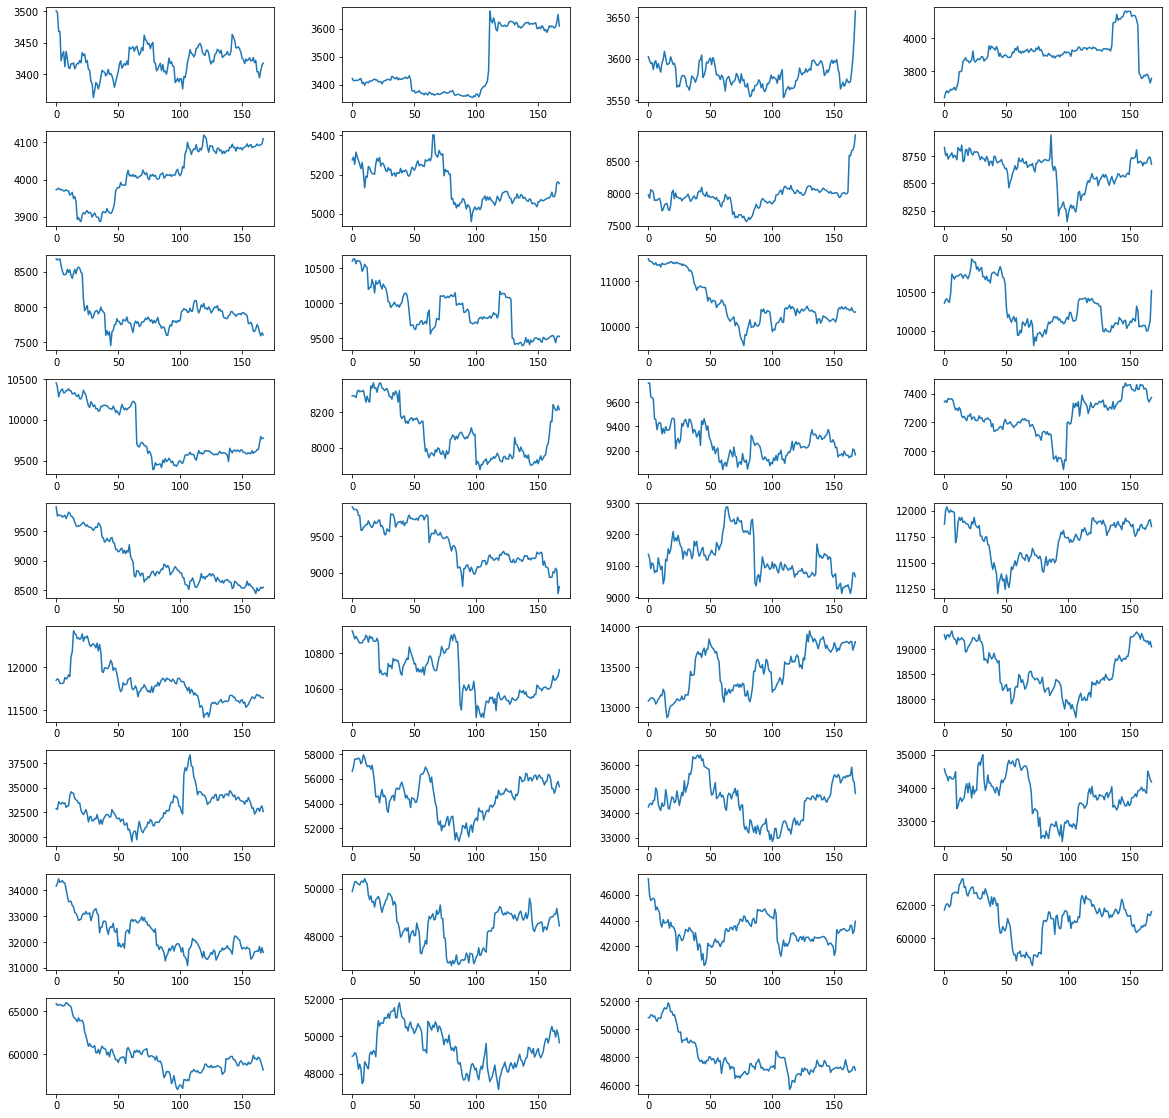

In [77]:
# reshape origin bitcoin price
Bit = bitcoin_price.values.reshape(int(len(bitcoin_price)/168), 168)

# plot the group which predicted data belongs to
a = [i for i, x in enumerate(cmeans_label) if x == 1]

count = 1
plt.subplots(figsize = (20, 20))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
for i in range(35):
    plt.subplot(9, 4, count)
    plt.plot(Bit[a[count-1], :].T)
    count+=1

plt.show()